In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import numpy as np
import json
import pickle
import random
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

true integral value: -5.7478307e-17
resolution n: 10 		 error: 5.0000000e-01, max error -4.4081626e-04, 0
resolution n: 100 		 error: 5.0000000e-01, max error 2.7638001e-04, 0
resolution n: 1000 		 error: 4.5529715e-17, max error -3.1848366e-04, 87
resolution n: 10000.0 		 error: -5.0907102e-17, max error -3.2016000e-06, 4174
resolution n: 100000.0 		 error: -4.1606973e-19, max error -2.9119150e-08, 41747


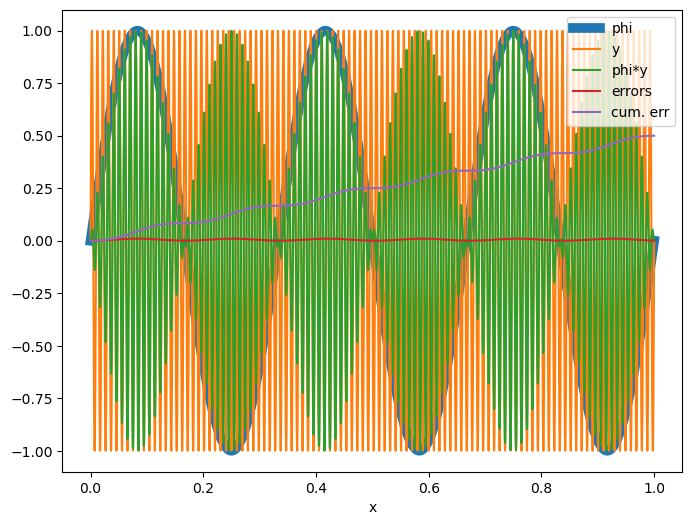

In [26]:
n_true = 1e2 # the "n" in the proof
n_plot = 1e4 # the n used for plotting
n_high_res = 1e6 # the n used for computing a low-error integral
sig_figs = 7

n_tests = [10, 100, 1000, 1e4, 1e5] # all the n's we will evaluate

omega = 3

x_plot = np.linspace(0, 1, int(n_plot))
x_true = np.linspace(0, 1, int(n_true))

def phi(x):
    # projection to the real part of the Fourier basis
    return np.sin(2*np.pi*omega*x)

def inverse(x):
    # didn't end up working
    f = np.sin(2*np.pi*omega*x)
    threshold = 5
    g = np.divide(4*x,f)
    g = np.nan_to_num(g, nan=threshold)
    mask = g > threshold
    g[mask] = threshold
    mask = g < -threshold
    g[mask] = -threshold
    return g

def approx_delta(x, thickness=1/n_true):
    f_x = np.sin(2*np.pi*(n_plot+omega)*x)
    f_x[f_x>0] = 1
    f_x[f_x<=0] = -1
    return f_x
    

def y(x):
#    return np.ones_like(x) # error 1e-17 (basically 0)
#    return x # error 1e-4 (order 1/n^2)
#    return 1000*x # .15 (order 1/n^2 * 1000)
#    return x **2 # 1e-7 (order 1/n^2)
#    return phi(x) # 1e-15 (basically 0)
#    return np.cos(2*np.pi*omega*x) # 1e-15
#    return np.sin(2*np.pi*(n_true)*x) # basically 0
    return np.sin(2*np.pi*(n_true + omega)*x) # -0.5 - very high error
#    return approx_delta(x) # -.66 - even higher error if non-lipschitz


def full_func(x):
    # this is y * Fourier basis; the function we want to integrate
    return np.multiply(phi(x),y(x))


def riemann_sum_full(f, n, debug=False):
    """Compute the right Riemann sum of f from 0 to 1 with n steps."""
    func = f(np.linspace(0, 1, int(n), endpoint=False))
    integral_value = sum(func / n)
    if debug:
        print('linspace full', np.linspace(0, 1, int(n), endpoint=False)[:5])
        print('function full', np.round(func[:5],5), n)
        print('full integral', f'{integral_value:.7e}')
    return integral_value

def riemann_sum_seq(f, n_highres, n, debug=False):
    """
    Compute the error of the right Riemann sum of f from 0 to 1 with n steps.
    n is the steps for which we compute the error.
    The integral with n_full steps is considered the ground truth
    """
    n_highres = int(n_highres)
    n = int(n)
    high_res_parts = np.zeros(n)
    low_res_parts = np.zeros(n)
    for i in range(n):
        func = f(np.linspace(i/n, (i+1)/n, int(n_highres/n), endpoint=False))
        high_res_parts[i] = sum(func) / int(n_highres/n) # "true integral, n_highres steps"
        low_res_parts[i] = func[0] # "approximation of integral, n steps"
    integral_high_res = sum(high_res_parts) / n
    integral_low_res = sum(low_res_parts) / n
    errors = (low_res_parts - high_res_parts) / n
    if debug:
        print('linspace summ', [i/n for i in range(n)][:5])
        print('function summ', np.round(low_res_parts[:5],5))
        print('summ integrals (low, high):', f'{integral_low_res:.7e}, {integral_high_res:.7e}')
    return high_res_parts, errors

true_integral = riemann_sum_full(full_func, n_high_res)
print('true integral value: {:.7e}'.format(true_integral))
for n_test in n_tests:
    full_error = riemann_sum_full(full_func, n_test) - true_integral
    seq_errors = riemann_sum_seq(full_func, n_high_res, n_test)[1]
    seq_error = sum(seq_errors)
    max_error = np.min(seq_errors)
    max_index = np.argmin(seq_errors)
    if np.abs(full_error - seq_error) > 1e-2:
        print(f"Diff. between full and seq errors. {full_error:.5e}, {seq_error:.5e}")
    print('resolution n:', n_test, '\t\t error: {:.7e}, max error {:.7e}, {}'.format(seq_error, max_error, max_index))

# plot phi, y, and phi*y (using n_plot)
plt.figure(figsize=(8,6))
plt.plot(x_plot, phi(x_plot), label='phi', linewidth=7.0)
plt.plot(x_plot, y(x_plot), label='y')
plt.plot(x_plot, full_func(x_plot), label='phi*y')

# plot the error and cumulative error of n_true 
errors = riemann_sum_seq(full_func, n_high_res, n_true)[1]
total_error = sum(errors)
max_error = np.max(errors)
cum_err = np.cumsum(errors)

#if max_error < .01:
#    cum_err /= min(max_error, cum_err[-1])
#    cum_err /= 10

plt.plot(x_true, errors, label='errors')
plt.plot(x_true, cum_err, label='cum. err')

plt.xlabel('x')
plt.legend()
plt.show()
